In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pandas import Series
import numpy.linalg as npl
from numpy import load,save 
from random import randrange
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KernelDensity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams["figure.figsize"] = (20,10)

import warnings
warnings.filterwarnings("ignore")

In [3]:
plt.rcParams["figure.figsize"] = (20,10)
import sys 
sys.path.append(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code')
from pca_ad_utils import *
from decomp_utils import *
from customizedLossSynthetic import *
from LocationAnomalyPCA import *
from utilsImputation import *


sys.path.append(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code\DataGenerator')
from ParamsEstimationUtils import *
sys.path.append(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code\DataGenerator')
from syntheticDataGeneratorUtils import *

In [4]:
nStocks = 20
T = 1
M = int(2.**10)
Ntrain = int(2.**10)
Ntest = int(2.**9)
N = Ntrain + Ntest
k=20

alpha = 0.9
windowSize = 206
upBound=0.04
AnoNumber = 5
isimul = 0

Cov = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code\DataGenerator\Params\Cov.csv').drop(['Unnamed: 0'],axis=1).values
S0 = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code\DataGenerator\Params\S0.csv').drop(['Unnamed: 0'],axis=1).values.reshape(-1,)
mu = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code\DataGenerator\Params\mu.csv').drop(['Unnamed: 0'],axis=1).values.reshape(-1,)
sigma = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code\DataGenerator\Params\Sigma.csv').drop(['Unnamed: 0'],axis=1).values.reshape(-1,)


In [5]:
X_trainUnderdf = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Data\XTrainUnder.csv').drop(['Unnamed: 0'],axis=1)
y_trainUnderdf = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Data\yTrainUnder.csv').drop(['Unnamed: 0'],axis=1)

X_testUnderdf = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Data\XTestUnder.csv').drop(['Unnamed: 0'],axis=1)
y_testUnderdf = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Data\yTestUnder.csv').drop(['Unnamed: 0'],axis=1)


In [6]:
X_trainUnder = np.array(X_trainUnderdf.iloc[:,:-3])
X_testUnder = np.array(X_testUnderdf.iloc[:,:-3])

y_trainUnder = np.array(y_trainUnderdf['NbAnomaly'])
y_testUnder = np.array(y_testUnderdf['NbAnomaly'])
ytrainUnder = np.array([1 if l==1 else 0 for l in y_trainUnder])
ytestUnder = np.array([1 if l==1 else 0 for l in y_testUnder])

print(f'Normal observations in train set {list(y_trainUnder).count(0)}')
print(f'Outlier observations in train set {list(y_trainUnder).count(1)} \n')

print(f'Normal observations in test set {list(y_testUnder).count(0)}')
print(f'Outlier observations in test set {list(y_testUnder).count(1)}')



k = 20

# Learning on TS 

model = PCA(n_components=k)
model.fit(X_trainUnder)
r_train = model.inverse_transform(model.transform(X_trainUnder))
r_test = model.inverse_transform(model.transform(X_testUnder))




reconsRawTrain = r_train
reconsRawTest = r_test


reconsRawTrain = torch.tensor(reconsRawTrain)
ytrain = torch.tensor(ytrainUnder.reshape(-1,1))


reconsRawTest = torch.tensor(reconsRawTest)
ytest = torch.tensor(ytestUnder.reshape(-1,1))
xtrain = np.array(X_trainUnder,dtype=float)
ytrain = np.array(y_trainUnder,dtype=float)

xtest = np.array(X_testUnder,dtype=float)
ytest = np.array(y_testUnder,dtype=float)

xtrain = torch.tensor(xtrain)
ytrain = torch.tensor(ytrain.reshape(-1,1))


xtest = torch.tensor(xtest)
ytest = torch.tensor(ytest.reshape(-1,1))

ErrRawTrain = xtrain - reconsRawTrain
ErrRawTrain = torch.tensor(ErrRawTrain)

ErrRawTest = xtest - reconsRawTest
ErrRawTest = torch.tensor(ErrRawTest)

Normal observations in train set 6010
Outlier observations in train set 6010 

Normal observations in test set 2109
Outlier observations in test set 421


In [7]:
NbSimul = 100
stocksName = ['S'+str(i) for i in range(20)]

ImputationError =  pd.DataFrame(columns=['Error','Stock','Method','iSimul'],
                                                           index=np.arange(20*4*NbSimul))

CovError = pd.DataFrame(columns=['Error','Method','iSimul'],index=np.arange((4+1)*NbSimul))

for iSimul in tqdm(range(NbSimul)):
    stocks,time = GBMsimulator(iSimul,S0,mu,sigma,Cov,T,N)
    dt = time

    StocksDFTrain = pd.DataFrame(stocks[:,:])
    n,d = StocksDFTrain.shape
    dfTSwAnomalyTrain,dfTSLabelTrain = AnomalyGeneratorDF(StocksDFTrain,AnoNumber,windowSize,alpha,upBound)


    stocksAnoImpuBF,stocksAnoImpuPCA,stocksAnoImpuLinear = Imputation(AnoTS=dfTSwAnomalyTrain,
                                                                  cleanTS=StocksDFTrain,
                                                                  modelPCA=model,windowsize=206)
    Res = EvalImputation(dfTSwAnomalyTrain,StocksDFTrain,stocksAnoImpuBF,stocksAnoImpuPCA,stocksAnoImpuLinear,AnoNumber).values
    ImputationError.iloc[iSimul*80:(iSimul+1)*80,0] = Res[:,:-1].flatten()
    ImputationError.iloc[iSimul*80:(iSimul+1)*80,1] = np.concatenate([stocksName,stocksName,
                                                                     stocksName,stocksName])
    ImputationError.iloc[iSimul*80:(iSimul+1)*80,2] = np.repeat(['BF','PCA','Linear','Ano'], 20)
    ImputationError.iloc[iSimul*80:(iSimul+1)*80,3] = iSimul
    
    
    CovError.iloc[iSimul*5:(iSimul+1)*5,:-2] = np.array(EvalImpuCov(dfTSwAnomalyTrain,StocksDFTrain,stocksAnoImpuBF,stocksAnoImpuPCA,stocksAnoImpuLinear,Cov,sigma)).reshape(-1,1)
    CovError.iloc[iSimul*5:(iSimul+1)*5,-2] = ['Ano','PCA','Linear','BF','Clean']
    CovError.iloc[iSimul*5:(iSimul+1)*5,-1] = iSimul

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  5.74it/s]


In [8]:
ImputationError

,Error,Stock,Method,iSimul
0,0.242578,S0,BF,0
1,0.033156,S1,BF,0
2,0.107087,S2,BF,0
3,0.19871,S3,BF,0
4,0.067125,S4,BF,0
...,...,...,...,...
7995,2.127758,S15,Ano,99
7996,0.751794,S16,Ano,99
7997,2.103457,S17,Ano,99
7998,2.945783,S18,Ano,99


In [36]:
ImputationError.to_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Results\ImputationEvaluation\ImputationError.csv')
CovError.to_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Results\ImputationEvaluation\CovError.csv')

## II. Results visualization

In [9]:
ImputationError = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Results\ImputationEvaluation\ImputationError.csv').drop(columns=['Unnamed: 0'])
CovError = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Results\ImputationEvaluation\CovError.csv').drop(columns=['Unnamed: 0'])

In [10]:
ImputationError = ImputationError.replace(['Linear'],['LI'])
CovError = CovError.replace(['Linear'],['LI'])

In [12]:
CovError['Error'] = CovError['Error'].astype(float) 

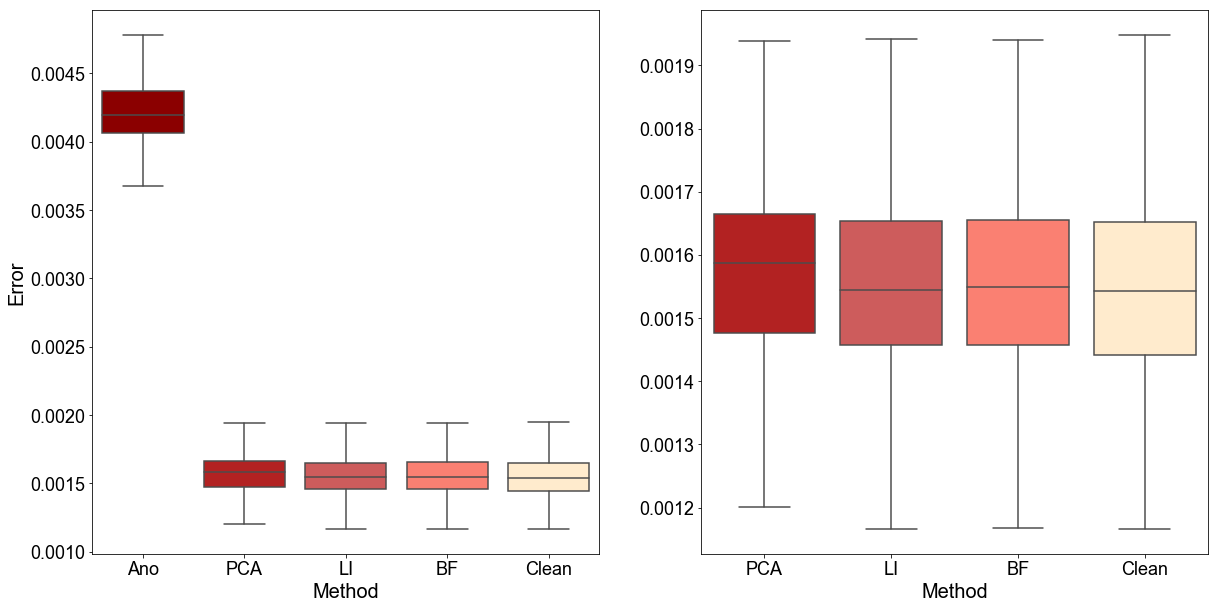

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))


CovErrorRestricted = CovError[CovError.Method != 'Ano']
sns.set(palette='deep')
Method = CovError.Method.unique() 
method_colors=["darkred","firebrick","indianred","salmon","blanchedalmond"]
color_dict = dict(zip(Method, method_colors))
bplot = sns.boxplot(x='Method',y='Error',data=CovError,showfliers=False,ax=ax[0])
for i in range(0,5):
    mybox = bplot.artists[i]
    mybox.set_facecolor(color_dict[Method[i]])
ax[0].set_xticklabels(ax[0].get_xticklabels(),fontsize=18)  
ax[0].tick_params(axis='y',labelsize=18)
ax[0].set_ylabel('Error',fontsize=20)
ax[0].set_xlabel('Method',fontsize=20)

Method = CovErrorRestricted.Method.unique() 
method_colors=["firebrick","indianred","salmon","blanchedalmond"]
color_dict = dict(zip(Method, method_colors))


bplot2 = sns.boxplot(x='Method',y='Error',data=CovErrorRestricted,showfliers=False,ax=ax[1])
for i in range(0,4):
    mybox = bplot2.artists[i]
    mybox.set_facecolor(color_dict[Method[i]])
ax[1].set_xticklabels(ax[1].get_xticklabels(),fontsize=18) 
ax[1].tick_params(axis='y',labelsize=18)
ax[1].set_ylabel('',fontsize=18)
ax[1].set_xlabel('Method',fontsize=20)
plt.savefig(r'C:\Users\nmadhar\Desktop\Conv_deep\Code\FinalPaper\Results\CovBox.pdf')
plt.savefig(r'C:\Users\nmadhar\Desktop\Conv_deep\Code\FinalPaper\Results\CovBox.png')

plt.show()

In [14]:
CovError.drop(columns=['iSimul']).groupby('Method').mean().T

Method,Ano,BF,Clean,LI,PCA
Error,0.004208,0.001554,0.001552,0.001554,0.001575


In [16]:
CovError.drop(columns=['iSimul']).groupby('Method').std().T

Method,Ano,BF,Clean,LI,PCA
Error,0.000272,0.000172,0.000173,0.00017,0.000165


In [17]:
ImputationError['Error'] = ImputationError['Error'].astype(float) 

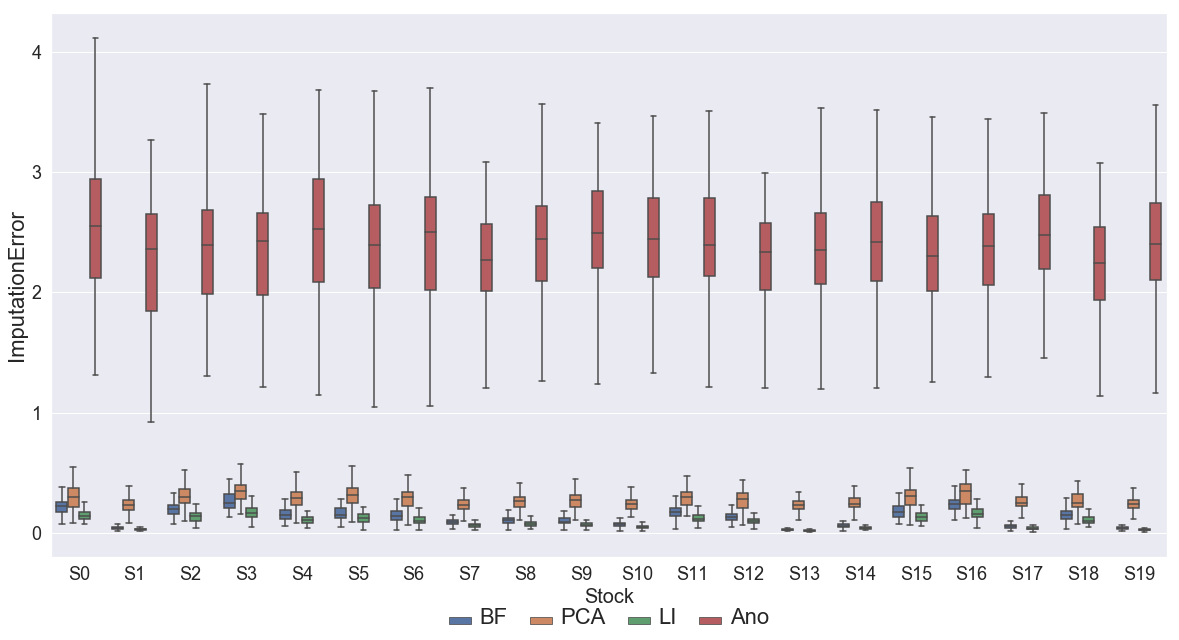

In [18]:
ax = sns.boxplot(x='Stock',y='Error',hue='Method',data=ImputationError,showfliers=False)
sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(0.5, -.15), ncol=4, title=None, frameon=False)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=18) 
ax.tick_params(axis='y',labelsize=18)
ax.set_ylabel('ImputationError',fontsize=22)
ax.set_xlabel('Stock',fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='32') # for legend title
#plt.savefig(r'C:\Users\nmadhar\Desktop\Conv_deep\Code\FinalPaper\Results\BoxplotStocksImput.pdf')
#plt.savefig(r'C:\Users\nmadhar\Desktop\Conv_deep\Code\FinalPaper\Results\BoxplotStocksImput.png')

plt.show()

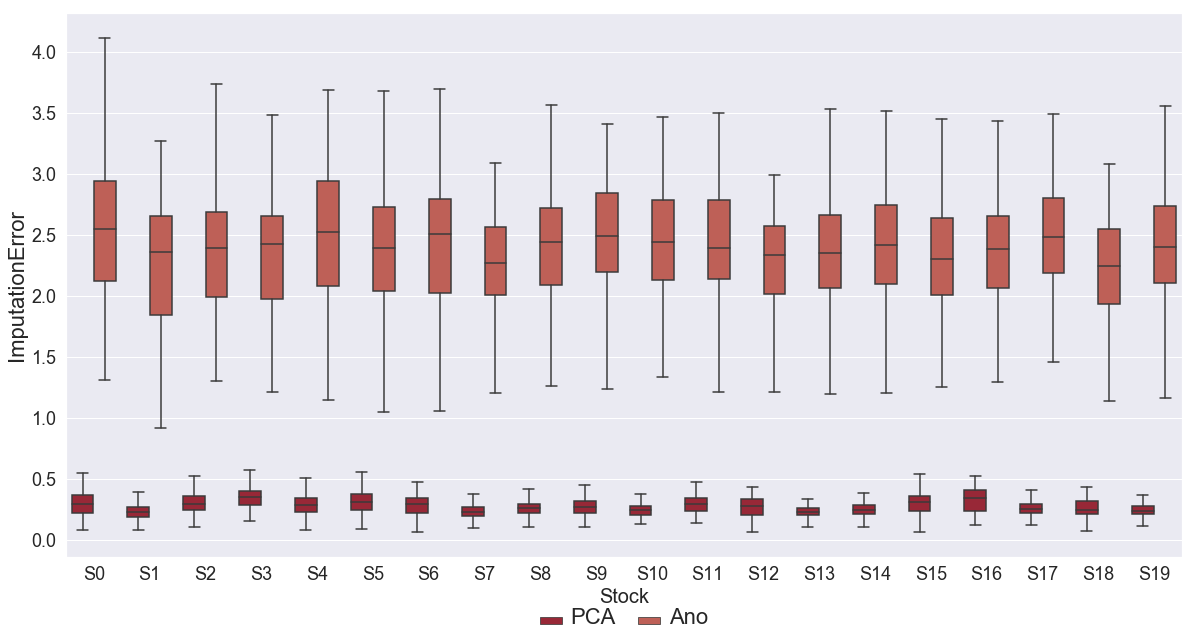

In [19]:
ImputationErrorRestricted = ImputationError[ImputationError.Method.isin(['Ano','PCA'])]

ax= sns.boxplot(x='Stock',y='Error',hue='Method',data=ImputationErrorRestricted,showfliers=False,palette =sns.color_palette('RdBu', n_colors=10) )
sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(0.5, -.15), ncol=4, title=None, frameon=False)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=18) 
ax.tick_params(axis='y',labelsize=18)
ax.set_ylabel('ImputationError',fontsize=22)
ax.set_xlabel('Stock',fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='32') # for legend title

#plt.savefig(r'C:\Users\nmadhar\Desktop\Conv_deep\Code\FinalPaper\Results\BoxplotStocksImputPCavsAno.pdf')
#plt.savefig(r'C:\Users\nmadhar\Desktop\Conv_deep\Code\FinalPaper\Results\BoxplotStocksImputPCAvsAno.png')


plt.show()